In [1]:
!pip install tensorflow_text
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 68.1 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [9]:
import pandas as pd
df = pd.read_csv('spamm.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [11]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [12]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [13]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [14]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [15]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [16]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [17]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [18]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1714,spam,Hard LIVE 121 chat just 60p/min. Choose your g...,1
3501,spam,Dorothy@kiefer.com (Bank of Granite issues Str...,1
2445,ham,"Yes but i dont care! I need you bad, princess!",0
4096,ham,I ain't answerin no phone at what is actually ...,0
5404,ham,Pls give her prometazine syrup. 5mls then &lt...,0


In [19]:
from sklearn.model_selection import train_test_split

# stratify is useful when dealing with imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [20]:
X_train.head(5)

1253    Yeah like if it goes like it did with my frien...
823     SMSSERVICES. for yourinclusive text credits, p...
4953    Welcome to Select, an O2 service with added be...
3954    Refused a loan? Secured or Unsecured? Can't ge...
2536    Can you pls pls send me a mail on all you know...
Name: Message, dtype: object

BERT TEXT CLASSIFICATION PART


In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
def get_sentence_embeddings(sentences):
  perprocessed_text = bert_preprocess(sentences)
  return bert_encoder(perprocessed_text)['pooled_output']

get_sentence_embeddings([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132727 , -0.88845736, ..., -0.7474886 ,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.5054396 , -0.9444668 , ..., -0.858475  ,
        -0.7174534 ,  0.8808297 ]], dtype=float32)>

Build Model


In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [27]:
len(X_train)

1120

In [28]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train The Model

In [29]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 355s 10s/step - loss: 0.6314 - accuracy: 0.6661 - precision: 0.6703 - recall: 0.6536
Epoch 2/10
35/35 [==============================] - 347s 10s/step - loss: 0.4963 - accuracy: 0.8250 - precision: 0.8227 - recall: 0.8286
Epoch 3/10
35/35 [==============================] - 346s 10s/step - loss: 0.4483 - accuracy: 0.8313 - precision: 0.8066 - recall: 0.8714
Epoch 4/10
35/35 [==============================] - 347s 10s/step - loss: 0.3826 - accuracy: 0.8821 - precision: 0.8677 - recall: 0.9018
Epoch 5/10
35/35 [==============================] - 344s 10s/step - loss: 0.3574 - accuracy: 0.8786 - precision: 0.8581 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 346s 10s/step - loss: 0.3375 - accuracy: 0.8920 - precision: 0.8765 - recall: 0.9125
Epoch 7/10
35/35 [==============================] - 345s 10s/step - loss: 0.3179 - accuracy: 0.8973 - precision: 0.8843 - recall: 0.9143
Epoch 8/10
35/35 [=======================

In [31]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 117s 10s/step - loss: 0.2436 - accuracy: 0.9412 - precision: 0.9508 - recall: 0.9305


[0.2435796856880188,
 0.9411764740943909,
 0.9508196711540222,
 0.9304812550544739]

In [32]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 117s 10s/step


In [33]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[178,   9],
       [ 13, 174]])

Text(50.722222222222214, 0.5, 'Truth')

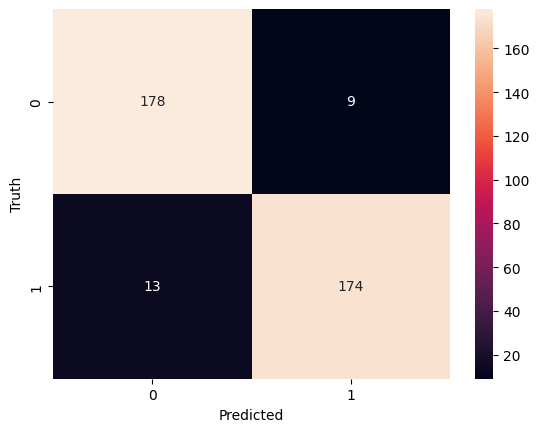

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       187
           1       0.95      0.93      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



Inference

In [30]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.73469406],
       [0.8297477 ],
       [0.7424022 ],
       [0.21483134],
       [0.11312179]], dtype=float32)